
<h1> 1<sup>st</sup> SWAN Users' Workshop </h1>

<h2> SWAN for HGCAL Test Beam Analysis </h2>

<h3> Quick usecase example </h3>


<footer>
  <p>Notebook by: Matteo Bonanomi</p>
  Contact information: <a href="mailto:matteo.bonanomi@cern.ch">
  matteo.bonanomi@cern.ch</a>.
</footer> 

In [1]:
import getpass
import os
if( os.system('klist | grep Default | grep mbonanom@CERN.CH') ):
    os.system('echo %s | kinit mbonanom' % getpass.getpass() )

Importing some libraries needed across the notebook.

In [2]:
import sys
import uproot
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from scipy.special import erf
from scipy.stats import iqr

Importing matplotlib for plots and setting some style features.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.colors import LogNorm
mpl.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

In [4]:
cms_hist = {'bins' : 80, 'histtype' : 'step', 'linewidth' : 2, 'density' : True}

In [52]:
cms_plt = {'linestyle' : '--', 'marker' : 'o', 'linewidth' : 2}

In [6]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)

Importing some user defined class for the HGCAL TB analysis.

In [7]:
from hgcalsw.data import read_ntuple as do_df
from hgcalsw.utils import observables as obs
from hgcalsw.fit import fit_functions as fit

In [27]:
SF = 0.92

In [88]:
plt.rcParams['figure.figsize'] = (10,6)

<h2> From ROOT TTrees to pandas dataframes </h2>

<h3> Everything without even needing ROOT :)  </h3>

There are several advantages of going from `ROOT` to `pandas` data frames:
 * Trivial one: we can perform the same analysis we would do in `ROOT` without having it installed, exploiting the `uproot` library to read the `TTrees` and convert them directly into a `pd.DataFrame()`;
 * Most of the time in a beam test analysis we are interested in producing *quickly* plots for comparisons and to decide in which direction move for the next step(s): the jupyter notebooks are an excellent tool to do this;
 * Our data are stored in `eos`: using SWAN we can directly access the files directly from the `eos` areas they are stored in;
 * We get rid of longs (and sometime difficult to read) `ROOT` macros.

Location and run number are the only user input needed for the creation of the dataframe.

In [8]:
def do_dataf(run, location, isMC=False, withDWC=True):
    '''
        Helper function to read TB ntuples.
        Works both for Data and MC.
        The final dataframe created contains the info
        about the hits and the DWC. Some preselection
        according to known problems is already applied.
    '''
    branches = [u'rechit_chip', 'rechit_module', 'rechit_channel',
                u'rechit_energy', 'rechit_layer']

    dwc_branches = [u'ntracks', 'dwcReferenceType', 'b_x', 'b_y'] 
    rh_branches = [branch for branch in branches if 'rechit' in branch]

    fname = location + 'ntuple_%i.root' %run
    if isMC:
        fname = location + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN.root' %run
    key='rechitntupler/hits'
    df = uproot.open(fname)[key].pandas.df(branches)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']

    if withDWC:
        key_dwc='trackimpactntupler/impactPoints'
        dwc = uproot.open(fname)[key_dwc].pandas.df(dwc_branches)
        dwc = dwc.reset_index(drop=True)
        dwc.index.names = ['event']
        df_dwc = df.join(dwc)    
        sel_dwc = (df_dwc.ntracks == 1) & (df_dwc.dwcReferenceType == 13)

    else:
        df_dwc = df#.copy()

    sel = (df_dwc.rechit_energy > 0.5)
    sel &= ~((df_dwc.rechit_chip == 3) & (df_dwc.rechit_channel == 22))
    sel &= ~((df_dwc.rechit_module == 78) & (df_dwc.rechit_chip == 0))

    if withDWC:
        sel &= sel_dwc
    
    df_sel = df_dwc[sel]#.copy()
    
    for name in df_sel.columns:
        if (name == 'rechit_chip') | (name == 'rechit_layer') | (name == 'rechit_module') | (name == 'rechit_channel') | (name == 'ntracks') | (name == 'dwcReferenceType'):
            df_sel[name] = df_sel[name].astype('int8')
        else: df_sel[name] = df_sel[name].astype('float16')
    
    if isMC: 
        return df_sel
    
    # This selection works only for data and it is necessary to remove pions contamination
    # Especially at 120 and 150 GeV (see Thorben's plots on mattermost).
    
    sel = (df_sel[(df_sel.rechit_energy>0.5) & (df_sel.rechit_layer>28) & (df_sel.rechit_layer<=40)].groupby('event').rechit_layer.size() < 80)
    df_sel = df_sel[sel].copy()

    return df_sel


In [9]:
run = 435; energy = 300
location = 'root://eoscms.cern.ch//eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v13_patch1/'
location_sim = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/v2/withMCP/EMN/Angle/'

Flattened dataframe containing all the information per event and the branches coming from the merge, and boolean selection, of two different TTrees.

In [10]:
%%time
df_sim = do_dataf(energy, location_sim, isMC=True, withDWC=False)

/usr/local/bin/start_ipykernel.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 45.8 s, sys: 28.8 s, total: 1min 14s
Wall time: 3min 44s


In [11]:
%%time
df_dt = do_dataf(run, location)

/usr/local/bin/start_ipykernel.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 9.44 s, sys: 6.11 s, total: 15.5 s
Wall time: 19.9 s


In [ ]:
df_dt = do_df.do_df(run, location)
df_sim = do_df.do_df(energy, location_sim, isMC=True, withDWC=False)

<h3> Reconstruction of the energy deposit in the calorimeter </h3>

Now we get a bit more into the details of the analysis. Let's create the energy spectrum for the events in this run.
What is happening behind the scenes:
 * We have created our dataframe applying all the preselection cuts needed to keep only interesting events;
 * We are collecting the sum of the `rechit_energy` variable for every event. This information is stored in the `total_energy` variable;
 * We can now plot this `pd.Series()` to look how the energy spectrum looks like.
 * More interesting: we can fit this distribution (using to `repeatedGausFit` routine) to retrieve the resolution and the energy measurement, which are the two observables we are interested to for our analysis.

In [14]:
total_energy = obs.get_totE(df_dt)
total_energy_sim = obs.get_totE(df_sim)

In [59]:
total_energy_sim = total_energy_sim*SF

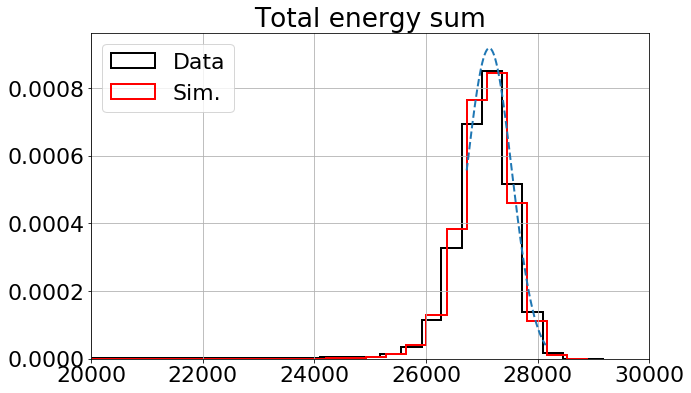

In [90]:
plt.title('Total energy sum')
r = plt.hist(total_energy, color = 'k', **cms_hist, label = 'Data')
r = plt.hist(total_energy_sim, color = 'r', **cms_hist, label = 'Sim.')
fit_f = fit.repeatedGausFit(total_energy_sim, energy, drawFit=True)
plt.xlim(20000, 30000)
plt.grid()
plt.legend(loc = 2)

Most of the physics results rely on some fitting procedures, i.e. finding the best curve (and its parameters) that describe our data. In this example we are interested in the **mean energy deposit** in the HGCAL prototype. This information can be extracted applying the `repeatedGausFit` routine we have developed (in `hgcalsw`) on the energy spectra shown above.

In [61]:
fit_data = fit.repeatedGausFit(total_energy, energy)
fit_sim = fit.repeatedGausFit(total_energy_sim, energy)

In [62]:
resolution = fit_data[0]; resolution_sim = fit_sim[0]
mean_energy = fit_data[2]; mean_energy_sim = fit_sim[2]

In [82]:
res_diff = abs(resolution - resolution_sim)/resolution_sim * 1e2

In [83]:
print('Discrepancy between Data and simulation estimated resolutions: %.2f %%' %res_diff)

Discrepancy between Data and simulation estimated resolutions: 2.73 %


<h3> Longitudinal profiles and energy deposit estimation </h3>

Using `pandas` data frames, all the selection operations become *quick* and *easy*. We can filter the events to look only into a specific region of the calorimeter. Namely, we are interested in the *electromagnetic compartment* (EE), i.e. only the first 29 layers. Hence we create a **boolean mask `EE_lay`** which we can use later on to select only these events.

In [41]:
EE_lay = df_dt.rechit_layer < 29
EE_sim = df_sim.rechit_layer < 29

We apply our bool masks on the two dataframes under study and we get the **longitudinal profiles**, i.e. the fraction of energy deposit per HGCAL layer, in the electromagnetic part of our calorimeter. Also in this case we use a module of the `hgcalsw` package: an external dependency easily installed directly from the Notebook :)
We use also `curve_fit`, a method of `scipy.optimize` to fit a function to data using non-linear least squares. In our case, the function used is defined in `hgcalsw.fit` and it is the `showerShape()` function. One of its parameters is the **energy deposit** in the calorimeter: a redundant information to crosscheck the result of our first fit on E sums.

In [43]:
profile = obs.get_longProf(df_dt[EE_lay])
profile_sim = obs.get_longProf(df_sim[EE_sim])

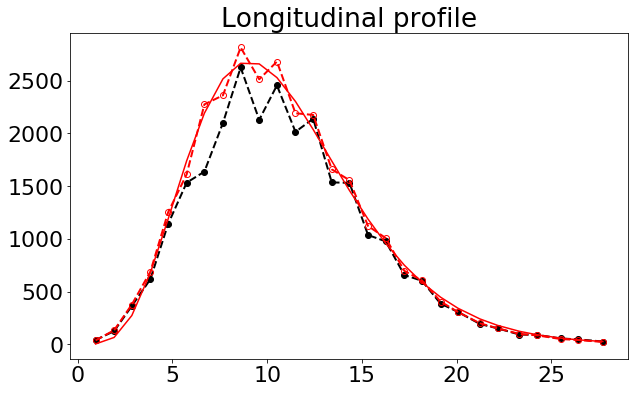

In [92]:
plt.title('Longitudinal profile')
plt.plot(profile, color = 'k', **cms_plt)
plt.plot(profile_sim, color = 'r', **cms_plt, mfc = 'None')
popt, pcov = curve_fit(fit.showerShape, profile_sim[1:].index, profile_sim[1:])
plt.plot(profile_sim.index, fit.showerShape(profile_sim.index, *popt), 'r-')

In [78]:
reco_diff = abs(mean_energy_sim - popt[2])/mean_energy_sim * 1e2

In [94]:
print('Discrepancy between the two reconstructed energies: %.2f %%' %reco_diff)

Discrepancy between the two reconstructed energies: 3.25 %


<h3> Shower depth </h3>

Another interesting observable that is worth a look is the shower depth distribution. This observable is computed per event in terms of `X0` according to the standard definition:
$\frac{\sum{E_i X_{0_i}}}{E_{Tot}}$.

In [47]:
cog = obs.do_COG(df_dt[EE_lay])
cog_sim = obs.do_COG(df_sim[EE_sim])

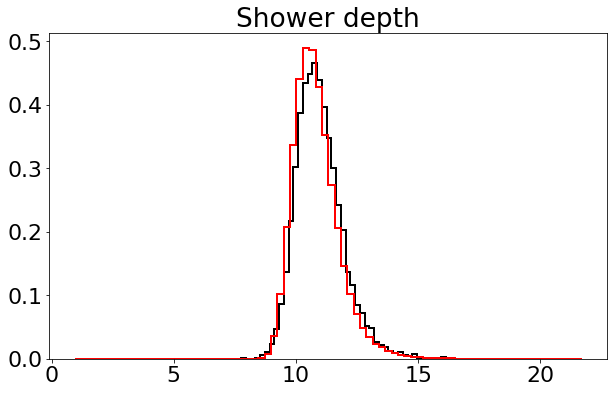

In [95]:
plt.title('Shower depth')
r = plt.hist(cog, color = 'k', **cms_hist)
r = plt.hist(cog_sim, color = 'r', **cms_hist)

In [85]:
cog_diff = abs(cog.mean() - cog_sim.mean())/cog_sim.mean()*1e2

In [87]:
print('Discrepancy between the average SD for Data and simulation: %.2f %%' %cog_diff)

Discrepancy between the average SD for Data and simulation: 1.38 %
